### Exploratory Data Analysis (EDA)

Detected label column: Type
Data shape: (178, 14)

Dtypes:
 Type                 int64
Alcohol            float64
Malic              float64
Ash                float64
Alcalinity         float64
Magnesium            int64
Phenols            float64
Flavanoids         float64
Nonflavanoids      float64
Proanthocyanins    float64
Color              float64
Hue                float64
Dilution           float64
Proline              int64
dtype: object

Missing values per column:
 Type               0
Alcohol            0
Malic              0
Ash                0
Alcalinity         0
Magnesium          0
Phenols            0
Flavanoids         0
Nonflavanoids      0
Proanthocyanins    0
Color              0
Hue                0
Dilution           0
Proline            0
dtype: int64

Head:
    Type  Alcohol  Malic   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0     1    14.23   1.71  2.43        15.6        127     2.80        3.06   
1     1    13.20   1.78  2.14        11.2        1

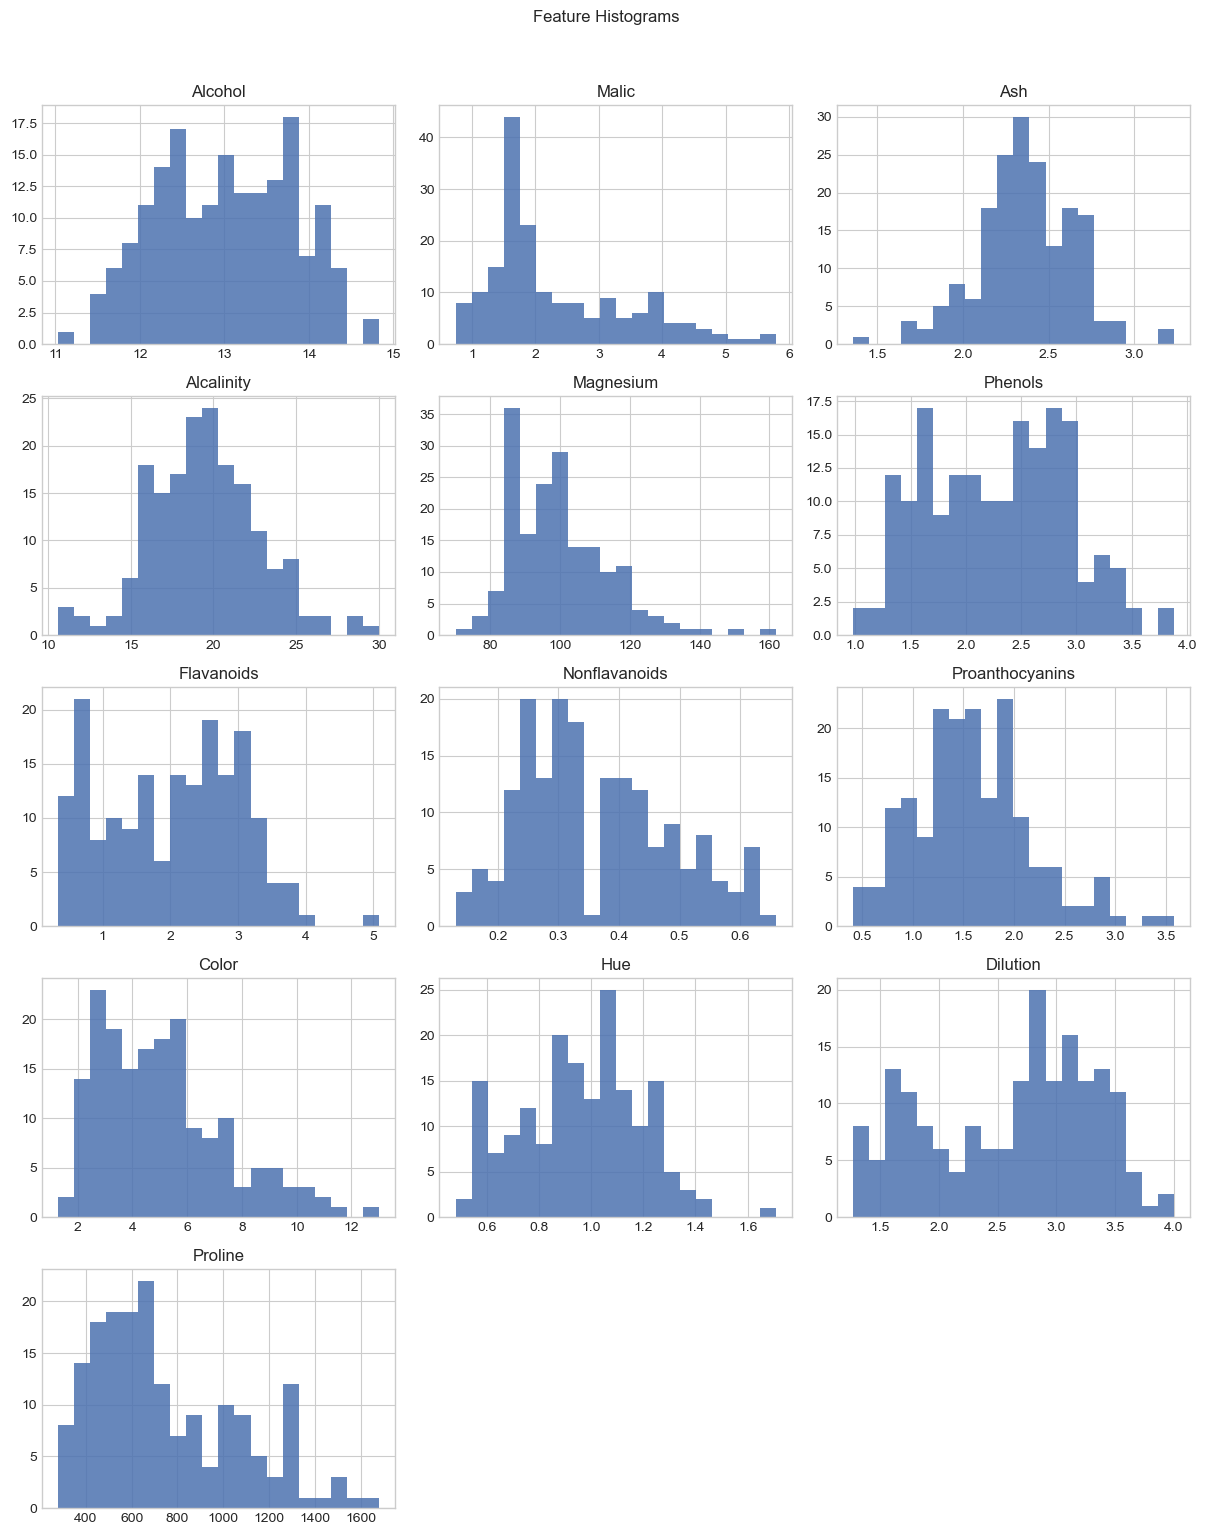

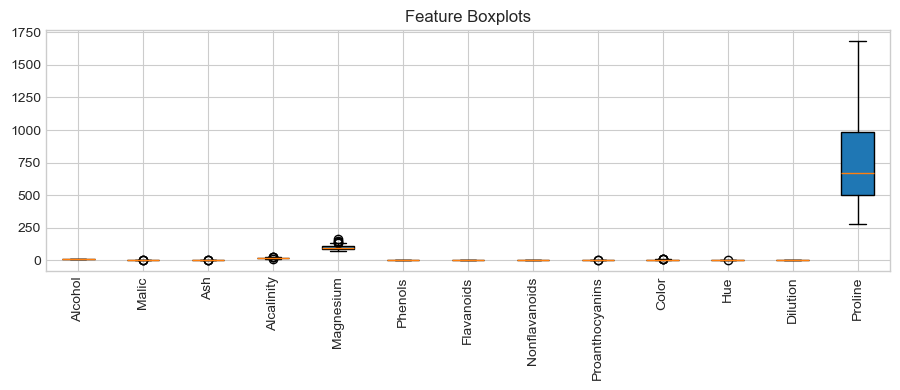

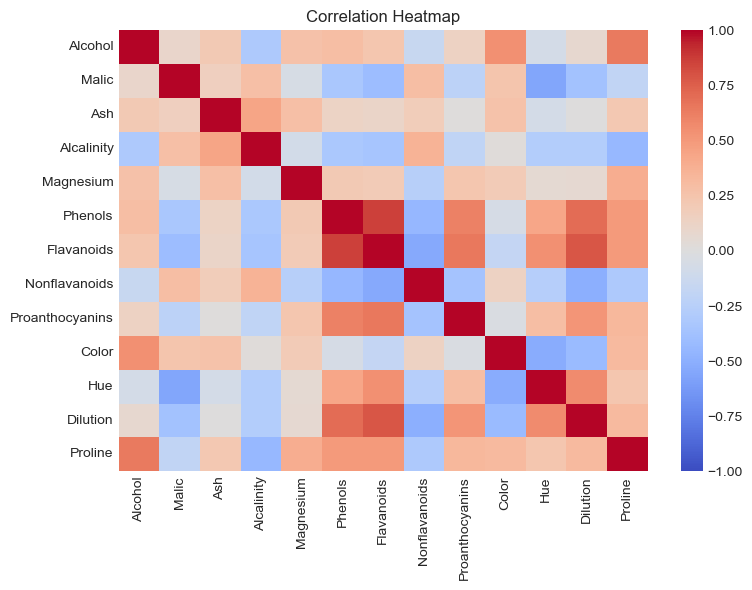

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use("seaborn-v0_8-whitegrid")

# Load dataset
CSV_PATH = "wine.csv"
df = pd.read_csv(CSV_PATH)

# Detect label column if present
label_col = None
for cand in ["Type", "type", "label", "Label", "target", "Target", "Class", "class"]:
    if cand in df.columns:
        label_col = cand
        break

y = df[label_col].copy() if label_col else None
X = df.drop(columns=[label_col]) if label_col else df.copy()
X = X.select_dtypes(include=[np.number]).copy()

print("Detected label column:", label_col)
print("Data shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
print("\nHead:\n", df.head())
print("\nNumeric feature columns:", list(X.columns))
print("Feature matrix shape:", X.shape)
print("\nDescribe (numeric):\n", X.describe().T)

# Distributions - histograms
num_cols = list(X.columns)
ncols = 3
nrows = int(np.ceil(len(num_cols) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
axs = axs.flatten()
for i, c in enumerate(num_cols):
    axs[i].hist(X[c], bins=20, alpha=0.85, color="#4C72B0")
    axs[i].set_title(c)
for j in range(i+1, len(axs)):
    axs[j].set_axis_off()
fig.suptitle("Feature Histograms", y=1.02)
plt.tight_layout()
plt.show()

# Distributions - boxplots
plt.figure(figsize=(max(8, 0.7*len(num_cols)), 4))
plt.boxplot([X[c] for c in num_cols], labels=num_cols, vert=True, patch_artist=True)
plt.xticks(rotation=90)
plt.title("Feature Boxplots")
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = X.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### Dimensionality Reduction with PCA

  PC  ExplainedVarianceRatio  CumulativeExplainedVariance
 PC1                0.361988                     0.361988
 PC2                0.192075                     0.554063
 PC3                0.111236                     0.665300
 PC4                0.070690                     0.735990
 PC5                0.065633                     0.801623
 PC6                0.049358                     0.850981
 PC7                0.042387                     0.893368
 PC8                0.026807                     0.920175
 PC9                0.022222                     0.942397
PC10                0.019300                     0.961697
PC11                0.017368                     0.979066
PC12                0.012982                     0.992048
PC13                0.007952                     1.000000


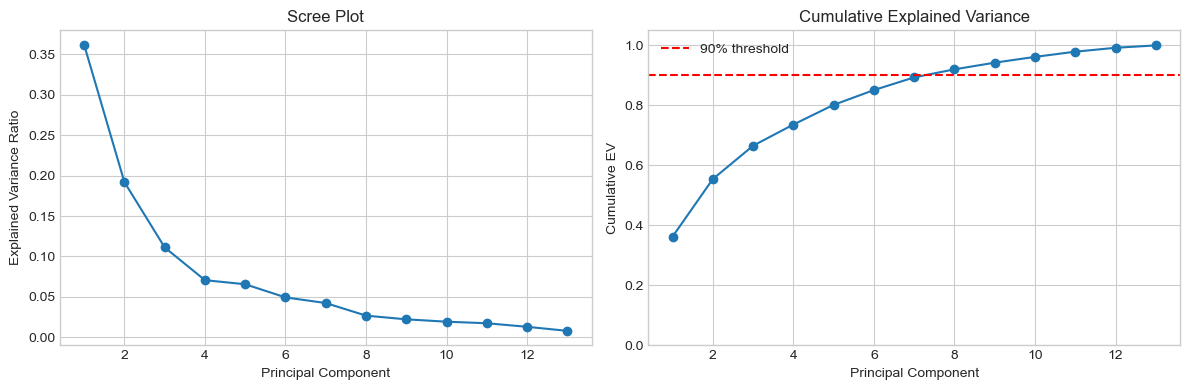

Suggested n_components (>=90% variance): 8


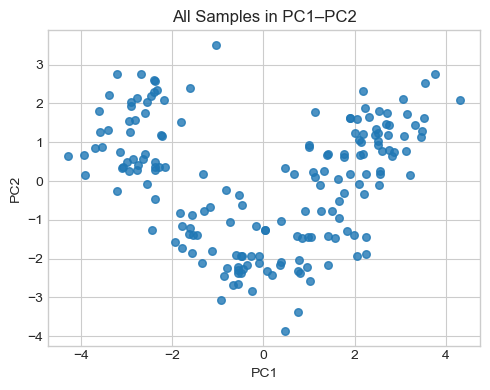


Component loadings (head):
       Alcohol     Malic       Ash  Alcalinity  Magnesium   Phenols  \
PC1  0.144329 -0.245188 -0.002051   -0.239320   0.141992  0.394661   
PC2  0.483652  0.224931  0.316069   -0.010591   0.299634  0.065040   
PC3 -0.207383  0.089013  0.626224    0.612080   0.130757  0.146179   
PC4 -0.017856  0.536890 -0.214176    0.060859  -0.351797  0.198068   
PC5 -0.265664  0.035214 -0.143025    0.066103   0.727049 -0.149318   

     Flavanoids  Nonflavanoids  Proanthocyanins     Color       Hue  Dilution  \
PC1    0.422934      -0.298533         0.313429 -0.088617  0.296715  0.376167   
PC2   -0.003360       0.028779         0.039302  0.529996 -0.279235 -0.164496   
PC3    0.150682       0.170368         0.149454 -0.137306  0.085222  0.166005   
PC4    0.152295      -0.203301         0.399057  0.065926 -0.427771  0.184121   
PC5   -0.109026      -0.500703         0.136860 -0.076437 -0.173615 -0.101161   

      Proline  
PC1  0.286752  
PC2  0.364903  
PC3 -0.126746  

In [ ]:
# Standardize features
scaler = StandardScaler()
Xs = scaler.fit_transform(X.values)

# Full PCA for diagnostics
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(Xs)

evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

ev_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(evr))],
    "ExplainedVarianceRatio": evr,
    "CumulativeExplainedVariance": cum
})
print(ev_df.to_string(index=False))

# Scree and cumulative plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, len(evr)+1), evr, marker="o")
ax[0].set_title("Scree Plot")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

ax[1].plot(range(1, len(cum)+1), cum, marker="o")
ax[1].axhline(0.90, color="red", linestyle="--", label="90% threshold")
ax[1].set_ylim(0, 1.05)
ax[1].set_title("Cumulative Explained Variance")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Cumulative EV")
ax[1].legend(frameon=False)

plt.tight_layout()
plt.show()

# Choose components to reach >= 90% variance
n90 = int(np.searchsorted(cum, 0.90) + 1)
print(f"Suggested n_components (>=90% variance): {n90}")

# Transform using chosen n_components
pca = PCA(n_components=n90, random_state=RANDOM_STATE)
Z = pca.fit_transform(Xs)

# Quick PC1–PC2 scatter
if Z.shape[1] >= 2:
    plt.figure(figsize=(5, 4))
    plt.scatter(Z[:, 0], Z[:, 1], s=30, alpha=0.8)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("All Samples in PC1–PC2")
    plt.tight_layout()
    plt.show()

# Component loadings
loadings = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print("\nComponent loadings (head):\n", loadings.head())

### Clustering with Original Data

Original data sweep metrics:
  K  silhouette  davies_bouldin
 2    0.259317        1.525997
 3    0.284859        1.389188
 4    0.260170        1.796892
 5    0.201619        1.808319
 6    0.237167        1.554394
 7    0.203628        1.660585
 8    0.157014        1.740859
 9    0.149882        1.708276
10    0.143638        1.706970

Best K (original): 3 | silhouette=0.2849 | DB=1.3892
Adjusted Rand Index vs 'Type' (original): 0.8975


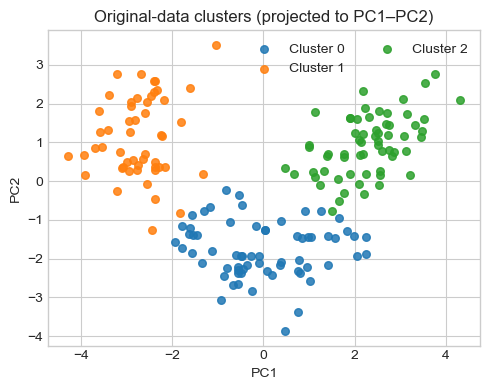

In [8]:
def sweep_kmeans(Xm, ks, random_state=RANDOM_STATE, n_init=10):
    results = []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = km.fit_predict(Xm)
        sil = silhouette_score(Xm, labels) if len(np.unique(labels)) > 1 else np.nan
        db  = davies_bouldin_score(Xm, labels)
        results.append({"K": k, "silhouette": sil, "davies_bouldin": db, "labels": labels})
    return results

k_range = list(range(2, 11))
orig_results = sweep_kmeans(Xs, k_range)

orig_metrics = pd.DataFrame([{"K": r["K"], "silhouette": r["silhouette"], "davies_bouldin": r["davies_bouldin"]} for r in orig_results])
print("Original data sweep metrics:\n", orig_metrics.to_string(index=False))

best_orig = max(orig_results, key=lambda r: (np.nan_to_num(r["silhouette"], nan=-np.inf)))
K_orig = best_orig["K"]
labs_orig = best_orig["labels"]
print(f"\nBest K (original): {K_orig} | silhouette={best_orig['silhouette']:.4f} | DB={best_orig['davies_bouldin']:.4f}")

if y is not None:
    ari_orig = adjusted_rand_score(y, labs_orig)
    print(f"Adjusted Rand Index vs '{label_col}' (original): {ari_orig:.4f}")

# Visualize original clusters in PC1–PC2
if Z.shape[1] >= 2:
    plt.figure(figsize=(5, 4))
    for c in np.unique(labs_orig):
        mask = labs_orig == c
        plt.scatter(Z[mask, 0], Z[mask, 1], s=30, alpha=0.85, label=f"Cluster {c}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Original-data clusters (projected to PC1–PC2)")
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()

PCA data sweep metrics:
  K  silhouette  davies_bouldin
 2    0.293005        1.354923
 3    0.314970        1.266882
 4    0.284641        1.639132
 5    0.268345        1.540258
 6    0.210268        1.617004
 7    0.191788        1.645185
 8    0.178838        1.565571
 9    0.168196        1.575642
10    0.171172        1.518480

Best K (PCA): 3 | silhouette=0.3150 | DB=1.2669
Adjusted Rand Index vs 'Type' (PCA): 0.8975


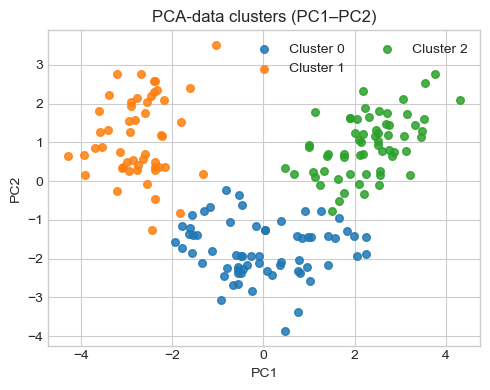

In [5]:
# Task 4: Clustering with PCA Data
# - KMeans on PCA-transformed features (Z)
# - Sweep K for metrics, pick best by silhouette
# - Visualize clusters in PC space, compute optional ARI

pca_results = sweep_kmeans(Z, k_range)

pca_metrics = pd.DataFrame([{"K": r["K"], "silhouette": r["silhouette"], "davies_bouldin": r["davies_bouldin"]} for r in pca_results])
print("PCA data sweep metrics:\n", pca_metrics.to_string(index=False))

best_pca = max(pca_results, key=lambda r: (np.nan_to_num(r["silhouette"], nan=-np.inf)))
K_pca = best_pca["K"]
labs_pca = best_pca["labels"]
print(f"\nBest K (PCA): {K_pca} | silhouette={best_pca['silhouette']:.4f} | DB={best_pca['davies_bouldin']:.4f}")

if y is not None:
    ari_pca = adjusted_rand_score(y, labs_pca)
    print(f"Adjusted Rand Index vs '{label_col}' (PCA): {ari_pca:.4f}")

# Visualize PCA clusters in PC1–PC2
if Z.shape[1] >= 2:
    plt.figure(figsize=(5, 4))
    for c in np.unique(labs_pca):
        mask = labs_pca == c
        plt.scatter(Z[mask, 0], Z[mask, 1], s=30, alpha=0.85, label=f"Cluster {c}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA-data clusters (PC1–PC2)")
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()


### Comparison and Analysis

In [ ]:
comp_df = pd.DataFrame({
    "K": k_range,
    "silhouette_orig": [r["silhouette"] for r in orig_results],
    "db_orig":         [r["davies_bouldin"] for r in orig_results],
    "silhouette_pca":  [r["silhouette"] for r in pca_results],
    "db_pca":          [r["davies_bouldin"] for r in pca_results],
})
print("Original vs PCA metrics across K:\n", comp_df.to_string(index=False))

common_K = 3
def get_by_k(results, k):
    return next((r for r in results if r["K"] == k), None)

r_o = get_by_k(orig_results, common_K)
r_p = get_by_k(pca_results, common_K)

if r_o and r_p:
    print(f"\nAt common K={common_K}:")
    print(f"  Orig -> silhouette={r_o['silhouette']:.4f}, DB={r_o['davies_bouldin']:.4f}")
    print(f"  PCA  -> silhouette={r_p['silhouette']:.4f}, DB={r_p['davies_bouldin']:.4f}")
    if y is not None:
        ari_o_k = adjusted_rand_score(y, r_o["labels"])
        ari_p_k = adjusted_rand_score(y, r_p["labels"])
        print(f"  ARI  -> Orig={ari_o_k:.4f}, PCA={ari_p_k:.4f}")

# Short analysis narrative (data-driven)
def safe_fmt(x):
    return "nan" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{x:.4f}"

print("\nAnalysis:")
print(f"- Best-K (Original): K={K_orig}, silhouette={safe_fmt(best_orig['silhouette'])}, DB={safe_fmt(best_orig['davies_bouldin'])}")
print(f"- Best-K (PCA):      K={K_pca}, silhouette={safe_fmt(best_pca['silhouette'])}, DB={safe_fmt(best_pca['davies_bouldin'])}")
if y is not None:
    print(f"- ARI at Best-K -> Original={safe_fmt(adjusted_rand_score(y, labs_orig))}, PCA={safe_fmt(adjusted_rand_score(y, labs_pca))}")
if r_o and r_p:
    if y is not None:
        print(f"- At K={common_K}, ARI comparison helps judge alignment with wine 'Type' classes when present.")
    print("- Compare silhouettes (higher better) and DB (lower better) to assess cluster compactness and separation.")

Original vs PCA metrics across K:
  K  silhouette_orig  db_orig  silhouette_pca   db_pca
 2         0.259317 1.525997        0.293005 1.354923
 3         0.284859 1.389188        0.314970 1.266882
 4         0.260170 1.796892        0.284641 1.639132
 5         0.201619 1.808319        0.268345 1.540258
 6         0.237167 1.554394        0.210268 1.617004
 7         0.203628 1.660585        0.191788 1.645185
 8         0.157014 1.740859        0.178838 1.565571
 9         0.149882 1.708276        0.168196 1.575642
10         0.143638 1.706970        0.171172 1.518480

At common K=3:
  Orig -> silhouette=0.2849, DB=1.3892
  PCA  -> silhouette=0.3150, DB=1.2669
  ARI  -> Orig=0.8975, PCA=0.8975

Analysis:
- Best-K (Original): K=3, silhouette=0.2849, DB=1.3892
- Best-K (PCA):      K=3, silhouette=0.3150, DB=1.2669
- ARI at Best-K -> Original=0.8975, PCA=0.8975
- At K=3, ARI comparison helps judge alignment with wine 'Type' classes when present.
- Compare silhouettes (higher better) and D

### Conclusion and Insights

In [ ]:
def fmt(v):
    return "nan" if (v is None or (isinstance(v, float) and np.isnan(v))) else f"{v:.4f}"

print("\n--- Conclusions ---")
print(f"Original best-K -> K={K_orig}, silhouette={fmt(best_orig['silhouette'])}, DB={fmt(best_orig['davies_bouldin'])}")
print(f"PCA     best-K -> K={K_pca}, silhouette={fmt(best_pca['silhouette'])}, DB={fmt(best_pca['davies_bouldin'])}")
if 'r_o' in globals() and 'r_p' in globals() and r_o and r_p:
    print(f"At common K={3} -> Orig: Sil={fmt(r_o['silhouette'])}, DB={fmt(r_o['davies_bouldin'])} | PCA: Sil={fmt(r_p['silhouette'])}, DB={fmt(r_p['davies_bouldin'])}")
if 'y' in globals() and y is not None:
    print(f"External validity (ARI) -> Original={fmt(adjusted_rand_score(y, labs_orig))}, PCA={fmt(adjusted_rand_score(y, labs_pca))}")

print("\nPractical implications:")
print("- Use PCA when features are correlated and a small number of PCs captures most variance, often improving cluster quality and stability.")
print("- Prefer original features when interpretability of raw variables is essential or when PCA reduces separation as indicated by metrics.")
print("- Always benchmark both pipelines across multiple K values and, if labels exist, include ARI for external validation.")

print("\nRecommendations:")
print("- Start with PCA targeting ~90% cumulative variance, then tune n_components if clustering metrics suggest under/over-compression.")
print("- Report both silhouette and Davies–Bouldin to present a balanced view of compactness and separation.")
print("- For reproducibility, fix random_state and document chosen K selection criteria (e.g., best silhouette or domain-driven K).")


--- Conclusions ---
Original best-K -> K=3, silhouette=0.2849, DB=1.3892
PCA     best-K -> K=3, silhouette=0.3150, DB=1.2669
At common K=3 -> Orig: Sil=0.2849, DB=1.3892 | PCA: Sil=0.3150, DB=1.2669
External validity (ARI) -> Original=0.8975, PCA=0.8975

Practical implications:
- Use PCA when features are correlated and a small number of PCs captures most variance, often improving cluster quality and stability.
- Prefer original features when interpretability of raw variables is essential or when PCA reduces separation as indicated by metrics.
- Always benchmark both pipelines across multiple K values and, if labels exist, include ARI for external validation.

Recommendations:
- Start with PCA targeting ~90% cumulative variance, then tune n_components if clustering metrics suggest under/over-compression.
- Report both silhouette and Davies–Bouldin to present a balanced view of compactness and separation.
- For reproducibility, fix random_state and document chosen K selection criteria 